In [99]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.optimize as opt
import scipy.integrate as integrate
import scipy.special
import cmath
from IPython.display import clear_output
a = 0.5             #width of a well
b = 0.5             #width of a barrier
V = 20.0             #height of a barrier
N = 150           #fragmentation of Brillouin zone from 0 to pi/(a+b)
N_r = 40        #fragmentation of lattice (for counting integrals in F)
A_SC = 2.39                #parameter in SC kernel
alph = 0.01                 #another parameter in SC
A_contact = 3.77            #parameter in contact kernel
A_LR = 15.                  #parameter in long-range kernel 
Volume = math.sqrt(N)*(a+b)
E_down = lambda E: math.cos(math.sqrt(2*E)*a) * math.cosh(b * math.sqrt(2 * V - 2 * E)) + \
                   (V / (2*E) - 1.) / math.sqrt(V/E - 1.) * math.sinh(math.sqrt(2*V - 2*E)*b) * \
                    math.sin(math.sqrt(2*E)*a) - math.cos(k * (a+b))
E_up = lambda E: math.cos(math.sqrt(2*E)*a) * math.cos(b * math.sqrt(2 * E - 2 * V)) + \
                   (V / (2*E) - 1.) / math.sqrt(1. - V/E) * math.sin(math.sqrt(2*E - 2*V)*b) * \
                    math.sin(math.sqrt(2*E)*a) - math.cos(k * (a+b))
k_map = numpy.arange(0,N) * 2. * math.pi/(a+b)/N - math.pi/(a+b)
#k_map = numpy.linspace(-math.pi/(a+b),math.pi/(a+b),N)
r_map = numpy.arange(0,N_r) * (a+b) / N_r - b
#r_map = numpy.linspace(-b,a,N_r)
for i in range (0, N_r):
    if (r_map[i]<=0):
        N_b = i
h = r_map[1] - r_map[0]
A1_v = numpy.zeros(N, dtype = complex)
A2_v = numpy.zeros(N, dtype = complex)
A1_c = numpy.zeros(N, dtype = complex)
A2_c = numpy.zeros(N, dtype = complex)
map = numpy.zeros((N,6))
fi = numpy.zeros((numpy.size(r_map),N,2), dtype = complex)
F = numpy.zeros((N,N), dtype = complex)
F_buf = numpy.zeros((numpy.size(r_map),N), dtype = complex)
Func_buf = numpy.zeros((numpy.size(r_map)), dtype = complex)
Func = numpy.zeros((numpy.size(r_map)), dtype = complex)

В столбцах массива *map* хранится следующая информация: энергия E, $\sqrt{2E}$, $\sqrt{2V-2E}$, причем столбцы 0 и 3 - это E для валентной зоны и зоны проводимости соответственно, 1 и 4 - $\sqrt{2E}$, 2 и 5 - $\sqrt{2V-2E}$ для v и c-зон соответственно. Номер строки соответсвует такому же по порядку значению из массива k_map

В массиве *fi* будет храниться значение волновой функции, первая координата соответсвует пространственное положение, вторая координата отвечает за значение волнового вектора, третья отвечает за зону и равна 0 для валентной и 1 для проводимости

В массиве *Id* хранится информация о том, как соотносится энергии E и V (чтобы понимать, по какой формуле считать связь между k и E: если V>E, то используем формулу E_down, если V<E, то E_up): для E>V Id=0, для E<V Id=1. Первая координата массива *Id* означает волновое число, вторая определяет зону так же, как и в массиве *fi*

Ниже выводится график зонной структуры. Так же здесь заполняется матрица Id. Программа строитзонную структуру по точкам E, по возрастанию (рассчитывая для каждой E соответствующее значенеи k). Как только k не может быть раситано по причине того, что значение косинуса должно по модулю превысить 1, начинается запрещенная зона. По порядковому номеру такого перехода определяется номер предшетсвующей зоны. Нас интересуют зоны 2 (валентная) и 3 (проводимости).
Построение зонной структуры происходит по формуле 
$$
cos (ka+kb) = cos (\sqrt{2 \epsilon} a) ch (\sqrt{2V_0 - 2\epsilon} b) + \frac{\frac{V_0}{2\epsilon} - 1}{\sqrt{ \frac{V}{\epsilon} - 1}} sin (\sqrt{2 \epsilon} a) sh (\sqrt{2V_0-2\epsilon} b) 
$$
в случае V>E, и 
\begin{equation}
cos (ka+kb) = cos (\sqrt{2 \epsilon} a) cos (\sqrt{2\epsilon - 2 V_0} b) + \frac{\frac{V_0}{2\epsilon} - 1}{\sqrt{1 - \frac{V}{\epsilon}}} sin (\sqrt{2 \epsilon} a) sin (\sqrt{2\epsilon - 2 V_0} b) 
\end{equation}
если V<E

('Gap from ', 28.48, ' to ', 32.94)
[6.44, 7.7, 19.92, 28.48, 32.94, 53.099999999999994]


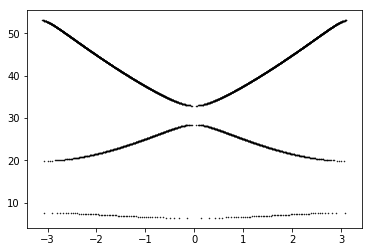

In [100]:
Func_down = lambda E: math.cos(math.sqrt(2*E)*a) * math.cosh(b * math.sqrt(2 * V - 2 * E)) + \
                   (V / (2*E) - 1.) / math.sqrt(V/E - 1.) * math.sinh(math.sqrt(2*V - 2*E)*b) * \
                    math.sin(math.sqrt(2*E)*a)
Func_up = lambda E: math.cos(math.sqrt(2*E)*a) * math.cos(b * math.sqrt(2 * E - 2 * V)) + \
                   (V / (2*E) - 1.) / math.sqrt(1. - V/E) * math.sin(math.sqrt(2*E - 2*V)*b) * \
                    math.sin(math.sqrt(2*E)*a)
checker = False
E_border = []
D = 1000
Id = numpy.zeros((N,2), dtype=int)
for i in range (1,D):
    E = i * V / D
    Efunc = Func_down(E)
    if math.fabs(Efunc) <= 1:
        if (checker == False):
            E_border.append(E)
            checker = True
        k = math.acos(Efunc) / (a+b)
        plt.plot(k, E, 'k.', marker='.', linestyle='dashed', linewidth=2,markersize=1)  
        k = -math.acos(Efunc) / (a + b)
        plt.plot(k, E, 'k.', marker='.', linestyle='dashed', linewidth=2, markersize=1)
    if math.fabs(Efunc) >1:
        if (checker == True):
            E_border.append(E-V/D)
            checker = False
M = len(E_border)
Anchor = numpy.zeros(4)
if (checker == False):
    if (M > 3):
        for i in range (0, N):
            Id[i,0] = 1
    if (M > 5):
        for i in range (0, N):
            Id[i,1] = 1
else:
    k_border = math.acos(Func_down(V*0.9999999999999))/(a+b)
    if (M==3):
        for i in range (0,N):
            k = k_map[i]
            if (abs(k)>k_border):
                Id[i,0] = 1
    elif (M==5):
        for i in range (0,N):
            k = k_map[i]
            if (abs(k)<k_border):
                Id[i,1] = 1
            Id[i,0] = 1
    elif (M > 5):
        for i in range (0,N):
            Id[i,0] = 1
            Id[i,1] = 1
count = 0
Ml = M
while (Ml<6):
    for i in range (int(D + D * 0.1 * count) + 1,int(D*1.1 + D * 0.1 * count)):
        E = i * V / D
        Efunc = Func_up(E)
        if math.fabs(Efunc) <= 1:
            if (checker == False):
                E_border.append(E)
                checker = True
            k = math.acos(Efunc) / (a+b)
            plt.plot(k, E, 'k.', marker='.', linestyle='dashed', linewidth=2,markersize=1)  
            k = -math.acos(Efunc) / (a + b)
            plt.plot(k, E, 'k.', marker='.', linestyle='dashed', linewidth=2, markersize=1)
        if math.fabs(Efunc) >1:
            if (checker == True):
                E_border.append(E-V/D)
                checker = False
    count = count + 1
    Ml = len(E_border)
if  (M==3):
    Anchor[0] = V * 0.99999
    Anchor[1] = V * 1.00001
    Anchor[2] = (E_border[4]+E_border[5])/2.
    Anchor[3] = Anchor[2]
elif (M==5):
    Anchor[2] = V * 0.99999
    Anchor[3] = V * 1.00001
    Anchor[0] = (E_border[2]+E_border[3])/2.
    Anchor[1] = Anchor[0]
elif (M==2):
    Anchor[1] = V * 1.00001
    Anchor[2] = (E_border[4]+E_border[5])/2.
    Anchor[3] = Anchor[2]
else:
    Anchor[0] = (E_border[2]+E_border[3])/2.
    Anchor[1] = Anchor[0]
    Anchor[2] = (E_border[4]+E_border[5])/2.
    Anchor[3] = Anchor[2]
print('Gap from ', E_border[3], ' to ', E_border[4])
print(E_border)
plt.show()

В следующем блоке считаются значения волновой функции *fi* в узловых точках по прямой и обратной ячейке решетки.

\begin{equation}
\begin{cases}
   \psi_{k1} (x) =   A_1 sin(\sqrt{2\epsilon} x) + A_2 cos ( \sqrt{2\epsilon} x) &\text{0 < x < a}\\
   \psi_{k2} (x) = A_1 \frac{\sqrt{2\epsilon}}{\sqrt{2V-2\epsilon}} sh(\sqrt{2\epsilon-2V_0} x) + A_2 ch( \sqrt{2\epsilon-2V_0} x) &\text{-b < x < 0}
 \end{cases}
\end{equation}

Для простоты эту систему будем записывать теперь в виде

\begin{equation}
\begin{cases}
   \psi_{k1} (x) =   A_1 f_1 + A_2 f_2 &\text{0 < x < a}\\
   \psi_{k2} (x) = A_1 g_1 + A_2 g_2 &\text{-b < x < 0}
 \end{cases}
\end{equation}

Связь между коэффициентами $A_1, A_2$ будем находить из граничного условия на волновую функцию в внешних границах ячейки: $x=-b, x=a$, где периодическая блоховская компонента волновой функции $u_k(x)=\psi_k(x) e^{-ikx}$ должна принимать одно и то же значение. Математически это условие приводит нас к уравнению на $A_2$ при условии, что $A_1$ мы принимаем за единицу $A_1 = 1$

\begin{equation}
A_2 = \frac{sin(\sqrt{2E} a) e^{-ik(a+b)}+\frac{\sqrt{2E}}{\sqrt{2V-2E}} sh(\sqrt{2V-2E}b)}{ch(\sqrt{2V-2E}b) - \
e^{-ik(a+b)}cos(\sqrt{2E}a)}
\end{equation}

Условие нормировки волновой функции на 1:

\begin{equation}
\int_{-b}^a |\Psi^2| dx \frac{1}{a+b} = 1 = \frac{1}{a+b} \int_{-b}^0 (A_1 g_1 + A_2 g_2) (A_1^* g_1 + A_2^* g_2) dx + \frac{1}{a+b} \int_0^a (A_1 f_1 + A_2 f_2) (A_1^* f_1 + A_2^* f_2) dx
\end{equation}

\begin{equation}
 1 = \frac{1}{a+b}(|A_1|^2 (\int_{-b}^0 g_1^2 dx + \int_0^a f_1^2 dx) + |A_2|^2 (\int_{-b}^0 g_2^2 dx + \int_0^a f_2^2 dx) + (A_1 A_2^* + A_1^* A_2) (\int_{-b}^0 g_1 g_2 dx + \int_0^a f_1 f_2 dx))
 \end{equation}
 
 Обознаив сумму интегралов после $|A_1|^2$ за $n_a$ (в коде это norm\_a), после $|A_2|^2$ за $n_b$ (в коде norm\_b), а после $(A_1^* A_2 + A_1 A_2^*)$ за $n_c$ (в коде norm\_c), получаем уравнение
 
 \begin{equation}
(|A_1|^2 n_a + |A_2|^2 n_b + (A_1^* A_2 + A_1 A_2^*) n_c) \frac{1}{a+b} = 1
 \end{equation}
 
Подстановка ненормированных $A_1$ и $A_2$ в это выражение, скорее всего, даст не 1, а некое отличное от единицы выражение norm. Нормировка волновых функций заключится в делении констант $A_1$ и $A_2$ на $\sqrt{norm}$

Интегралы в $n_a$, $n_b$, $n_c$  легко берутся аналитически:
 
  \begin{equation}
n_a = -\frac{sin(2 \sqrt{2 \epsilon } a)}{4 \sqrt{2 \epsilon}} + a/2 +
\frac{\epsilon}{2V - 2\epsilon} [\frac{sh(2b\sqrt{2V - 2\epsilon}}{2\sqrt{2V-2\epsilon}} - b]
 \end{equation}
 
   \begin{equation}
n_b = \frac{sin(2 \sqrt{2 \epsilon } a)}{4 \sqrt{2 \epsilon}} + a/2 +
\frac{sh(2b\sqrt{2V - 2\epsilon}}{4\sqrt{2V-2\epsilon}} + b/2 
 \end{equation}
 
   \begin{equation}
n_c = \frac{sin^2(a\sqrt{2\epsilon})}{2\sqrt{2\epsilon}} - \frac{\sqrt{2\epsilon}}{4V - 4\epsilon} sh^2 (b\sqrt{2V - 2\epsilon})
 \end{equation}

In [101]:
for i in range (0,N):
    k = k_map[i]
    if (Id[i,0] == 1):
        l = opt.fsolve(E_down, Anchor[0])
    else:
        l = opt.fsolve(E_up, Anchor[1])   
    map[i,0] = l[0]
    if (Id[i,1] == 1):
        l = opt.fsolve(E_down, Anchor[2])
    else:
        l = opt.fsolve(E_up, Anchor[3])
    map[i,3] = l[0]
    map[i,1] = math.sqrt(2 * map[i,0])
    if (Id[i,0] == 0):
        map[i, 2] = math.sqrt(2 * map[i,0] - 2*V)
    else:
        map[i, 2] = math.sqrt(2 * V - 2 * map[i, 0])
    map[i,4] = math.sqrt(2 * map[i,3])
    if (Id[i,1] == 0):
        map[i,5] = math.sqrt(2 * map[i,3] - 2 * V)
    else:
        map[i, 5] = math.sqrt(2 * V - 2 * map[i, 3])
    if (Id[i,0] == 0):
        norm_a = a / 2. - math.sin(2 * map[i, 1] * a) / (4 * map[i, 1]) \
                  + map[i, 0] / (2 * map[i, 0]- 2 * V) * (-math.sin(2 * b * map[i, 2]) / (2. * map[i, 2]) + b)
        norm_b = a / 2. + math.sin(2 * map[i, 1] * a) / (4 * map[i, 1]) \
                  + b / 2. + math.sin(2 * b * map[i, 2]) / (4 * map[i, 2])
        norm_c = (math.sin(a * map[i, 1])) ** 2 / (2. * map[i, 1]) \
                  - map[i, 1] / (4 * map[i, 0] - 4 * V) * (math.sin(b * map[i, 2])) **2
        A2_v[i] = (cmath.exp(-1.j * k_map[i] *(a+b))*math.sin(map[i,1]*a)+map[i,1]/map[i,2]*math.sin(map[i,2]*b))\
        /(math.cos(map[i,2]*b) - cmath.exp(-1.j*k_map[i]*(a+b))*math.cos(map[i,1]*a))
    else:
        norm_a = a / 2. - math.sin(2 * map[i, 1] * a) / (4 * map[i, 1]) \
                      + map[i, 0] / (2 * V - 2 * map[i, 0]) * (math.sinh(2 * b * map[i, 2]) / (2. * map[i, 2]) - b)
        norm_b = a / 2. + math.sin(2 * map[i, 1] * a) / (4 * map[i, 1]) \
                      + b / 2. + math.sinh(2 * b * map[i, 2]) / (4 * map[i, 2])
        norm_c = (math.sin(a * map[i, 1])) ** 2 / (2. * map[i, 1]) \
                      - map[i, 1] / (4 * V - 4 * map[i, 0]) * (math.sinh(b * map[i, 2])) ** 2
        A2_v[i] = (cmath.exp(-1.j * k_map[i] *(a+b))*math.sin(map[i,1]*a)+map[i,1]/map[i,2]*math.sinh(map[i,2]*b))\
        /(math.cosh(map[i,2]*b) - cmath.exp(-1.j*k_map[i]*(a+b))*math.cos(map[i,1]*a))
    
    norm = (norm_a + norm_b*(abs(A2_v[i]))**2 + norm_c * A2_v[i] + norm_c * A2_v[i].conjugate())/(a+b)
    A1_v[i] = 1./cmath.sqrt(norm)
    A2_v[i] = A2_v[i]/cmath.sqrt(norm)
    if (Id[i,1] == 0):
        norm_a = a / 2. - math.sin(2 * map[i, 4] * a) / (4 * map[i, 4]) \
                  + map[i, 3] / (2 * map[i, 3]- 2 * V) * (-math.sin(2 * b * map[i, 5]) / (2. * map[i, 5]) + b)
        norm_b = a / 2. + math.sin(2 * map[i, 4] * a) / (4 * map[i, 4]) \
                  + b / 2. + math.sin(2 * b * map[i, 5]) / (4 * map[i, 5])
        norm_c = (math.sin(a * map[i, 4])) ** 2 / (2. * map[i, 4]) \
                  - map[i, 4] / (4 * map[i, 3] - 4 * V) * (math.sin(b * map[i, 5])) **2
        A2_c[i] = (cmath.exp(-1.j * k_map[i] *(a+b))*math.sin(map[i,4]*a)+map[i,4]/map[i,5]*math.sin(map[i,5]*b))\
            / (math.cos(map[i,5]*b) - cmath.exp(-1.j*k_map[i]*(a+b))*math.cos(map[i,4]*a))
    else:
        norm_a = a / 2. - math.sin(2 * map[i, 4] * a) / (4 * map[i, 4]) \
                      + map[i, 3] / (2 * V - 2 * map[i, 3]) * (math.sinh(2 * b * map[i, 5]) / (2. * map[i, 5]) - b)
        norm_b = a / 2. + math.sin(2 * map[i, 4] * a) / (4 * map[i, 4]) \
                      + b / 2. + math.sinh(2 * b * map[i, 5]) / (4 * map[i, 5])
        norm_c = (math.sin(a * map[i, 4])) ** 2 / (2. * map[i, 4]) \
                      - map[i, 4] / (4 * V - 4 * map[i, 3]) * (math.sinh(b * map[i, 5])) ** 2
        A2_c[i] = (cmath.exp(-1.j * k_map[i] *(a+b))*math.sin(map[i,4]*a)+map[i,4]/map[i,5]*math.sinh(map[i,5]*b))\
            / (math.cosh(map[i,5]*b) - cmath.exp(-1.j*k_map[i]*(a+b))*math.cos(map[i,4]*a))
    norm = (norm_a + norm_b*(abs(A2_c[i]))**2 + norm_c*A2_c[i] + norm_c*A2_c[i].conjugate())/(a+b)
    A1_c[i] = 1./cmath.sqrt(norm)
    A2_c[i] = A2_c[i]/cmath.sqrt(norm)


for i in range (0, N_b):
    for j in range (0,N):
        if (Id[j,0] == 0):
            fi[i, j, 0] = A1_v[j] * math.sin(map[j, 2] *r_map[i]) * map[j, 1] / map[j, 2] \
            + A2_v[j] * math.cos(map[j, 2] * r_map[i])
        else:
            fi[i, j, 0] = A1_v[j] * math.sinh(map[j, 2] * r_map[i]) * map[j, 1] / map[j, 2] \
            + A2_v[j] * math.cosh(map[j, 2] * r_map[i])
        if (Id[j,1] == 0):
            fi[i, j, 1] = A1_c[j] * math.sin(map[j, 5] * r_map[i]) * map[j, 4] / map[j, 5] \
            + A2_c[j] * math.cos(map[j, 5] * r_map[i])
        else:
            fi[i, j, 1] = A1_c[j] * math.sinh(map[j, 5] * r_map[i]) * map[j, 4] / map[j, 5] \
            + A2_c[j] * math.cosh(map[j, 5] * r_map[i])

for i in range (N_b, N_r):
    for j in range (0,N):
        fi[i, j, 0] = A1_v[j] * math.sin(map[j, 1] * r_map[i]) + A2_v[j] * math.cos(map[j, 1] * r_map[i])
        fi[i, j, 1] = A1_c[j] * math.sin(map[j, 4] * r_map[i]) + A2_c[j] * math.cos(map[j, 4] * r_map[i])

(Не обязателен) В следующем блоке проверяется, что полученные волновые функции удовлетворяют граничному условию $u_k'(a)=u_k'(-b)$, где $u_k(x)$ - периодическая компонента волновой функции в форме Блоха

Выводится модуль разности $\Delta = u_k'(a)-u_k'(-b)$. Если он маленький для всех значений волнового вектора, то все в порядке. Левый столбец содержит дельты для функций из валентной зоны, правый - проводимости

(Не обязателен) В следующем блоке проверяется, что полученные волновые функции нормированы на единицу. Левый столбец содержит нормы для функций из валентной зоны, правый - проводимости

Норма считается как $\frac{1}{a+b}\int_{-b}^a |\psi_k^i(r)|^2 dr$ , где i - номер зоны

In [102]:
check = numpy.zeros(N_r)
checker = True
for j in range (0,N):
    check = abs(fi[:,j,0])**2
    sum1 = integrate.trapz(check,x=None,dx=h)/(a+b)
    check = abs(fi[:,j,1])**2
    sum2 = integrate.trapz(check,x=None,dx=h)/(a+b)
    if (abs(1. - sum1) > 0.001):
        checker = False
    if (abs(1. - sum2) > 0.001):
        checker = False
        
if checker == True:
    print('OK')
else:
    print('enlarge N_r')

enlarge N_r


(Опционально) Этот блок считает $F^{vcvc}$ посредством Soft-Colomb ядра $f_{xc}^{SC}(x,x')=\frac{-A^{SC}}{\sqrt{\alpha+(x-x')^2}}$

Само F определяется как $F_{HXC,\bf{k},\bf{k'}}^{ijmn} = \frac{2}{\Omega^2} \int_{\Omega} d r\int_{\Omega} d r'\phi_{i,\bf{k}}^*(\bf{r}) \phi_{j,\bf{k}}^*(\bf{r}) f_{HXC} (\bf{r}, \bf{r'}, \omega) \phi_{m,\bf{k'}}^*(\bf{r'}) \phi_{n,\bf{k'}}^*(\bf{r'})$; здесь $\Omega$ - размер одномерной ячейки

In [103]:
for i in range (0,N):
    for j in range (0,N):
        if (i<=j):
            for x in range (0, N_r):
                for r in range (0, N_r):
                    Func_buf[r] = - fi[r, j, 0] * fi[r, j, 1].conjugate() * A_SC / math.sqrt((r_map[x] - r_map[r]) ** 2 + alph)
                Func[x] = integrate.trapz(Func_buf,x=None,dx=h) * fi[x,i,0].conjugate() * fi[x,i,1]
            F[i,j] = integrate.trapz(Func,x=None,dx=h) * 2 / Volume**2
    clear_output(wait=True)
    print(int((i+1) * 100. / N), "% done of counting F")
for i in range (0,N):
    for j in range (0,N):
        if (i>j):
            F[i,j] = F[j,i]

(100, '% done of counting F')


(Опционально) Этот блок считает F посредством контактного ядра $f_{xc}^{cont}(x,x')=-A^{cont}\delta (x-x')$

In [95]:
for i in range (0,N):
    for j in range (0,N):
        if (i<=j):
            for x in range (0, N_r):
                Func_buf[x] =  -fi[x, j, 0] * fi[x, j, 1].conjugate() * A_contact * fi[x,i,0].conjugate() * fi[x,i,1]
            F[i,j] = integrate.trapz(Func_buf,x=None,dx=h) * 2 / Volume**2
    clear_output(wait=True)
    print(int((i+1) * 100. / N), "% done of counting F")
for i in range (0,N):
    for j in range (0,N):
        if (i>j):
            F[i,j] = F[j,i]

(100, '% done of counting F')


Экспериментальное ядро (нестабильно к изменению разбиения по прямой ячейке - скорее всего, из-за искуственного зануления функции в бесконечности)

In [139]:
for i in range (0,N):
    for j in range (0,N):
        if (i<=j):
            for x in range (0, N_r):
                for r in range (0, N_r):
                    if (x == r):
                        fxc = 0.
                    else:
                        fxc = A_LR / (4 * math.pi * abs(r_map[x]-r_map[r]))
                    Func_buf[r] = - fi[r, j, 0] * fi[r, j, 1].conjugate() * fxc
                Func[x] = integrate.simps(Func_buf,x=None,dx=h) * fi[x,i,0].conjugate() * fi[x,i,1]
            F[i,j] = integrate.simps(Func,x=None,dx=h) * 2 / Volume**2
    clear_output(wait=True)
    print(int((i+1) * 100. / N), "% done of counting F")
for i in range (0,N):
    for j in range (0,N):
        if (i>j):
            F[i,j] = F[j,i]

(100, '% done of counting F')


Здесь выводится матрца F(k,k'), а потом решается уравнение (21) как задача на поиск собственных векторов.

[ 4.3605698   4.44274359  4.45913085  4.51581263  4.53809562  4.64472993
  4.66689438  4.82128053  4.84173543  5.03968657  5.05802707  5.29452361
  5.31085457  5.58067848  5.59536628  5.89350827  5.90703034  6.22893771
  6.24177144  6.58347414  6.5960222   6.95416445  6.96672244  7.33852602
  7.35128606  7.73447539  7.74754828  8.14026413  8.15370475  8.55442374
  8.56825188  8.97571857  8.98993376  9.40310607  9.4176971   9.8357033
  9.85065415 10.27275919 10.28805251 10.71363162 10.72925069 11.15776859
 11.17369838 11.60469282 11.62092044 12.05398907 12.07050398 12.50529378
 12.5220878  12.95828661 12.97535378 13.41268336 13.43001982 13.8682302
 13.88583403 14.32469883 14.34256994 14.7818825  14.80002241 15.23959259
 15.25800439 15.69765584 15.71634402 16.1559119  16.17488229 16.61421134
 16.63347102 17.07241385 17.0919711  17.53038678 17.55025105 17.98800382
 18.00818568 18.44514385 18.46565499 18.90168993 18.92254316 19.35752843
 19.37873768 19.81254815 19.83412852 20.26663962 20.2

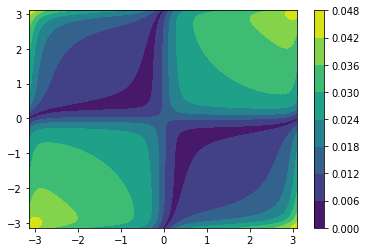

In [104]:
x, y = numpy.meshgrid(k_map, k_map)
fig = plt.contourf(x, y, abs(F))
plt.colorbar(fig)
for i in range(0, N):
    for j in range (0, N):
        if (i == j):
            F[i,j] = F[i,j] + map[j,3] - map[j,0]
fr,v = numpy.linalg.eigh(F)
print(fr)

Вывод графиков зависимости квадрата плотности состояния $|\rho^{cv}(k)|^2$, которому соответсвует честота перехода w, от волнового числа. Num - порядковый номер собственного числа (и соответствующего собственного вектора)

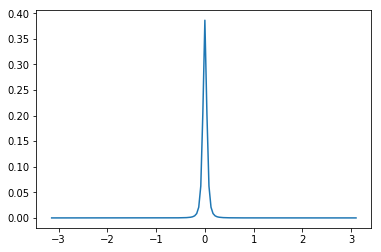

In [106]:
Num=0
fig, ax = plt.subplots()
ax.plot(k_map, (abs(v[:,Num]))**2)
plt.show()

Здесь будет считаться $Im (\epsilon)$ и строиться ее график по формуле 

$
\epsilon_M=1-lim_{q->0} 4\pi \sum_{\lambda} \frac{|< c|e^{-iqr}|v > \rho^{cv}|^2}{\omega-\omega_{\lambda}+i\mu}
$

, где $< v|e^{-iqr}|c > = \int_{-b}^{a} \psi^v(r) e^{-iqr} \psi^{c*}(r) dr $, $\mu$ отвечает за сглаживание пиков на частотах, совпадающих с собственными частотами уравнения Ванье

In [ ]:
q=(0.1)**16
w_map = numpy.linspace(0., 5., 1000)
F_fr = numpy.zeros(numpy.size(w_map), dtype = complex)
Int1 = numpy.zeros(N_r, dtype = complex)
Int2 = numpy.zeros(N_r, dtype = complex)
ME = numpy.zeros(N, dtype = complex)

for n in range (0, N):
    for i in range (0,N):
        for r in range (0, N_r):
            Int1[r] = fi[r,i,0] * fi[r,i,1].conjugate() * cmath.exp(-1.j * q * r_map[r]) / (a+b)
        ME[n] = ME[n] + (integrate.simps(Int1,x=None,dx=h) * v[i,n])
    ME[n] = abs(ME[n])**2
    clear_output(wait=True)
    print(((n+1) * 100 / numpy.size(fr)), "% done of counting ME")

for w in range (0, numpy.size(w_map)):
    for n in range (0, N):
        F_fr[w] = F_fr[w] + ME[n] / (w_map[w] - fr[n] + 1.j * 0.2)
    F_fr[w] = 1 - 4 * math.pi * F_fr[w]
    
fig, ax = plt.subplots()
ax.plot(w_map,F_fr.imag)
plt.show()

(100, '% done of counting ME')
